<a href="https://colab.research.google.com/github/nhatpd/2021-Summer-School/blob/main/PG-for-MultinomialLogisticRegression-with-L21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Proximal gradient algorithms for Softmax Regression with Group Lasso

In [ ]:
import numpy as np 
from sklearn import datasets
iris = datasets.load_iris()
X = iris["data"] #[:, (2, 3)]  # petal length, petal width
y = iris["target"]

In [ ]:
test_ratio = 0.2
validation_ratio = 0.2
total_size = len(X)

test_size = int(total_size * test_ratio)
validation_size = int(total_size * validation_ratio)
train_size = total_size - test_size - validation_size

rnd_indices = np.random.permutation(total_size)

X_train = X[rnd_indices[:train_size]]
y_train = y[rnd_indices[:train_size]]
X_valid = X[rnd_indices[train_size:-test_size]]
y_valid = y[rnd_indices[train_size:-test_size]]
X_test = X[rnd_indices[-test_size:]]
y_test = y[rnd_indices[-test_size:]]

Softmax function:

$\hat{p}_k(x) = \dfrac{\exp(W_{:,k}^Tx + b_k)}{\sum_{j=1}^K\exp(W_{:,j}^Tx + b_j)}$

Objective function: f + R, where

$f(\mathbf{W}) =
- \dfrac{1}{n}\sum\limits_{i=1}^{n}\sum\limits_{k=1}^{K}{y_i^k\log\left(\hat{p}_k(x_i)\right)}$

$R(W) = \|W\|_{2,1} = \sum_{i=1}^d\|W_{i,:}\|_2$

Gradient:

$\nabla f(\mathbf W) = \dfrac{1}{n} \sum\limits_{i=1}^{n}{ \left ( \hat{p}_k(x_i) - y^k_i \right ) \mathbf{x}_i}$


In [ ]:
import time
import numpy as np
from sklearn.metrics import accuracy_score
class MLogisticR:

  def __init__(self, W0, eta = 0.01, maxIter = 1000, alpha = 0.1, maxTime = None, tol = None):

    self.W = W0
    self.eta = eta
    self.maxIter = maxIter
    self.alpha = alpha
    self.maxTime = maxTime
    self.tol = tol
    self.Time = []
    self.obj = []
    self.acc_train = []
    self.nnz = []

  def ProxL21(self, V, gamma):
    norm2 = np.linalg.norm(V,axis=1)
    V[norm2 < gamma] = 0
    V[norm2 >= gamma] = (1-gamma/norm2[norm2 >= gamma]).reshape(-1,1)*V[norm2 >= gamma]
    return V
  def softmax(self, XW):
    exps = np.exp(XW)
    exp_sums = np.sum(exps, axis=1, keepdims=True)
    return exps / exp_sums
  
  def to_one_hot(self, y):
    K = y.max() + 1
    n = len(y)
    Y_one_hot = np.zeros((n, K))
    Y_one_hot[np.arange(n), y] = 1
    return Y_one_hot

  def fit(self, X_train, y_train, eval = True):

    n, d = X_train.shape

    X_train = np.c_[np.ones((n, 1)), X_train]

    y_train_one_hot = self.to_one_hot(y_train)
    
    XW = X_train.dot(self.W)

    prob = self.softmax(XW)

    for iter in range(self.maxIter):
      
      start_time = time.time()

      error = prob - y_train_one_hot

      grad = 1/n * X_train.T.dot(error)

      V = self.W - self.eta * grad

      self.W = self.ProxL21(V,self.eta*self.alpha)

      XW = X_train.dot(self.W)

      prob = self.softmax(XW)

      self.Time.append(time.time() - start_time)
      if eval:
        f_val = -np.mean(np.sum(y_train_one_hot * np.log(prob + 1e-7), axis=1))
        
        norm2 = np.linalg.norm(self.W,axis=1)

        self.obj.append(f_val + self.alpha*np.sum(norm2))

        self.nnz.append(np.count_nonzero(norm2))

        y_pred = np.argmax(prob, axis=1)

        self.acc_train.append(accuracy_score(y_train,y_pred))
        #stopping conditions
        if self.maxTime is not None:
          if np.sum(self.Time) > self.maxTime:
            print('Stopped by MaxTime at ',iter,'-th iterattion')
            break
        if self.tol is not None:
          if np.abs(self.obj[-1] - self.obj[-2]) <= self.tol:
            print('Stopped by the objective value at ',iter,'-th iterattion')
            break

  def predict(self, X_test):
    n, d = X_test.shape
    X_test = np.c_[np.ones((n, 1)), X_test]
    prob = self.softmax(X_test.dot(self.W))

    y_pred = np.argmax(prob, axis=1)
    return y_pred

In [ ]:
d = X_train.shape[1]
K = len(np.unique(y_train))
W0 = np.random.randn(d+1, K)
MLR = MLogisticR(W0,maxIter=5000,alpha=0)

In [ ]:
MLR.fit(X_train,y_train)

In [ ]:
y_t_pred=MLR.predict(X_test)
np.mean(y_test == y_t_pred)

0.9

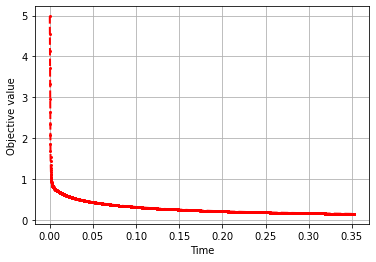

In [ ]:
import matplotlib.pyplot as plt

plt.plot(np.cumsum(MLR.Time), MLR.obj, 'o-', color='red', markersize=2, linewidth =2, linestyle='--')

plt.xlabel('Time')
plt.ylabel('Objective value')
# plt.title("")
plt.grid(True)

Experiment on orlraws10P 

In [ ]:
!pip install wget
import wget

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9672 sha256=45da6e29e6daeb3a082b45b54cd11d6ddf947a0d823debdfed9d2dd7a0584178
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [ ]:
wget.download('https://jundongl.github.io/scikit-feature/files/datasets/orlraws10P.mat','orlraws10P.mat')

'orlraws10P.mat'

In [ ]:
import scipy.io
orl = scipy.io.loadmat('orlraws10P.mat')

In [ ]:
X = orl['X']
y = orl['Y']

In [ ]:
test_ratio = 0.2
validation_ratio = 0.2
total_size = len(X)

test_size = int(total_size * test_ratio)
validation_size = int(total_size * validation_ratio)
train_size = total_size - test_size# - validation_size

rnd_indices = np.random.permutation(total_size)

X_train = X[rnd_indices[:train_size]]
y_train = y[rnd_indices[:train_size]].T[0]-1
# X_valid = X[rnd_indices[train_size:-test_size]]
# y_valid = y[rnd_indices[train_size:-test_size]].T[0]-1
X_test = X[rnd_indices[-test_size:]]
y_test = y[rnd_indices[-test_size:]].T-1


In [ ]:
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
X_train = std.fit_transform(X_train)
X_test = std.transform(X_test)
# X_valid = std.transform(X_valid)

In [ ]:
d = X_train.shape[1]
K = len(np.unique(y_train))
W0 = np.zeros([d+1, K])
MLR = MLogisticR(W0,eta =0.01, maxIter=5000,maxTime=5,alpha=0.2)
MLR.fit(X_train,y_train)
y_t_pred=MLR.predict(X_test)
print(np.mean(y_test == y_t_pred))

Stopped by MaxTime at  691 -th iterattion
0.95


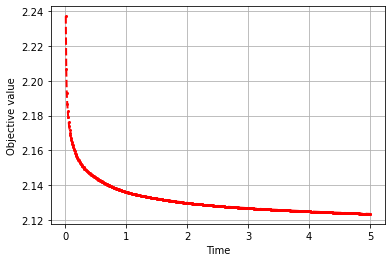

In [ ]:
import matplotlib.pyplot as plt

plt.plot(np.cumsum(MLR.Time), MLR.obj, 'o-', color='red', markersize=2, linewidth =2, linestyle='--')

plt.xlabel('Time')
plt.ylabel('Objective value')
# plt.title("")
plt.grid(True)

Exercise:

1. Prove that f is a convex and $L$-smooth function
2. Implement an early stopping condition
3. Implement an accelerated proximal algorithm
4. Test on multi-class data sets downloaded from https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/